In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

**STEP 1: IMPORTING ALL THE NECESARY LIBRARIES:**
The code starts by importing the required libraries for data manipulation, visualization, and building the Convolutional Neural Network (CNN) model with highest possible accuracy using tensorflow.

In [10]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

**STEP 2: SETTING UP THE DATASET PATHS AND DIRECTORIES:**

In [11]:
# Set the path to the dataset
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Training")
test_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

Here, the dataset_path variable is set to the root path of the brain tumor MRI dataset. The training and testing directories are defined by joining the dataset path with the specific subdirectories.

**STEP 3: LOADING AND PREPROCESSING THE DATASET:**
The code reads the images from each category in the training directory, counts the number of images in each category, and creates a Pandas DataFrame (train_df) to store the image filenames, corresponding categories, and counts.

A bar plot is generated to visualize the distribution of tumor types in the training dataset.

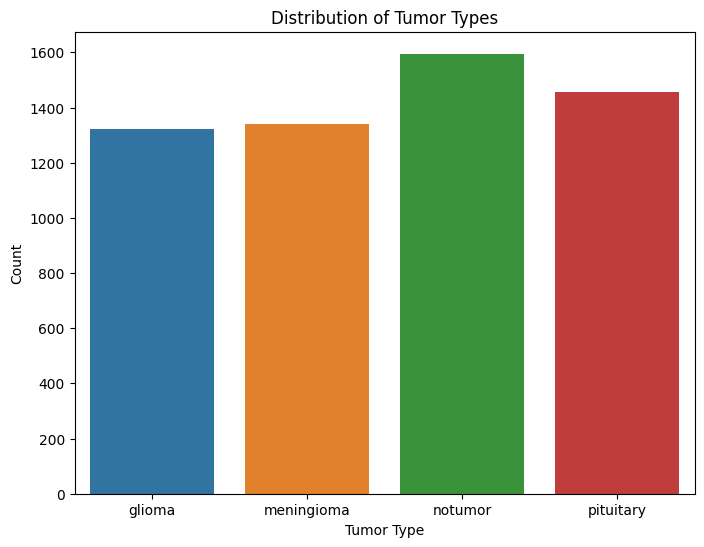

In [12]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

**STEP 4: VISUALIZING IMAGES FOR EACH TUMOR TYPES:**
Here, the code displays sample images for each tumor type using a grid of subplots.

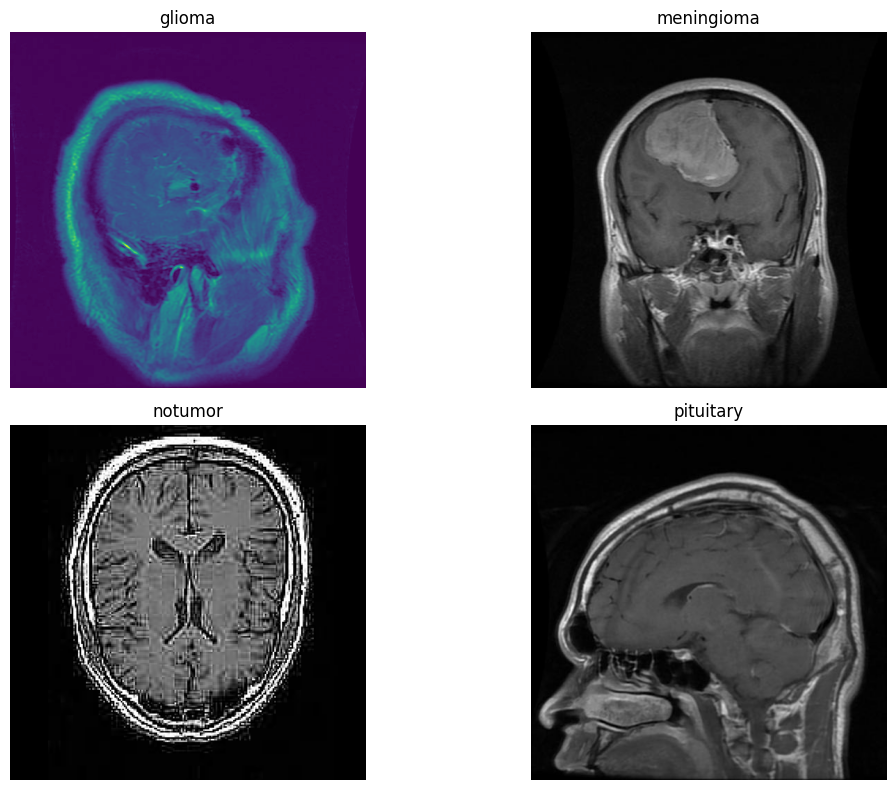

In [13]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

**STEP 5: SETTING UP THE IMAGE_SIZE, BATCH_SIZE AND EPOCHS FOR THE MODEL:**
The image_size variable defines the desired size for the input images in the CNN. The batch_size specifies the number of images to be processed in each training batch, and epochs determines the number of times the entire training dataset is iterated during training.

In [14]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

**STEP 6: DATA AUGMENTATION AND PREPROCESSING:**

In [15]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


DATA AUGMENTATION is performed using ImageDataGenerator class from Keras. It applies various transformations to the training imags to artificially increase the size of the dataset and improve the generalization. The aumentation paramters include rescaling the pixel values, rotation, shifting, shearing, zooming and flipping. The train_generator is created using the augmented data, and the test_generator is created with only pixel rescaling for the test dataset.

**STEP 7: BUILDING THE MODEL ARTITECHURE**

In [16]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The model architecture is defined using a sequential model (Sequential class). It consists of a series of convolutional (Conv2D) and max pooling (MaxPooling2D) layers, followed by a flattening layer, two fully connected (Dense) layers, and a dropout layer for regularization.
The activation function used for the convolutional layers is ReLU, except for the last dense layer, where softmax activation is used to output class probabilities.
The model is compiled with the Adam optimizer, which is an adaptive learning rate optimization algorithm. The loss function used is categorical cross-entropy, suitable for multi-class classification problems with one-hot encoded labels.
The accuracy metric is also specified to monitor the model's performance during training.

In [17]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4653 - loss: 1.1312 - val_accuracy: 0.5930 - val_loss: 1.1649
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2:17 779ms/step - accuracy: 0.7188 - loss: 0.8848

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7188 - loss: 0.8848 - val_accuracy: 0.8387 - val_loss: 0.6272
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 172s 955ms/step - accuracy: 0.7093 - loss: 0.7210 - val_accuracy: 0.6219 - val_loss: 0.9367
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.7763 - val_accuracy: 0.4194 - val_loss: 1.2628
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 203s 969ms/step - accuracy: 0.7558 - loss: 0.6199 - val_accuracy: 0.7625 - val_loss: 0.6555
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7500 - loss: 0.6614 - val_accuracy: 0.7097 - val_loss: 0.6598
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 174s 966ms/step - accuracy: 0.8005 - loss: 0.5124 - val_accuracy: 0.7703 - val_loss: 0.7094
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8438 - loss: 0.4366 - val_accuracy: 0.7742 - val_loss: 0.5842
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 174s 965ms/step - accuracy: 0.8172 - loss: 0.4739 - val_accurac

The model is trained using the fit method. The train_generator provides the training data, and the test_generator provides the validation data. The steps_per_epoch and validation_steps are set to ensure that the entire training and validation datasets are processed in one epoch. The training progress and performance metrics are stored in the history object.

**STEP 8: VISUALIZATION THROUGH GRAPH** 

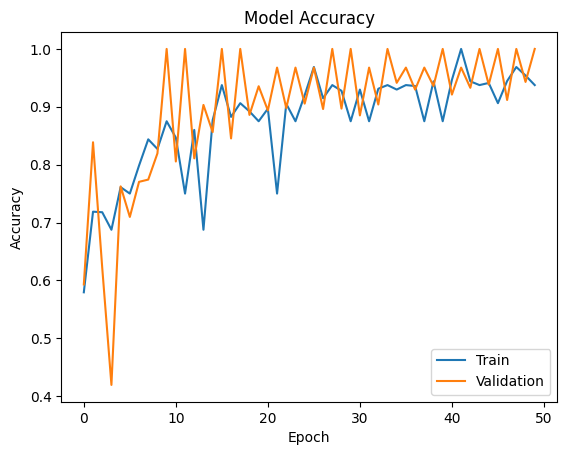

In [18]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

This code plots the training and validation accuracy over epochs using the data stored in history. It helps visualize the model's learning progress and check for overfitting or underfitting.

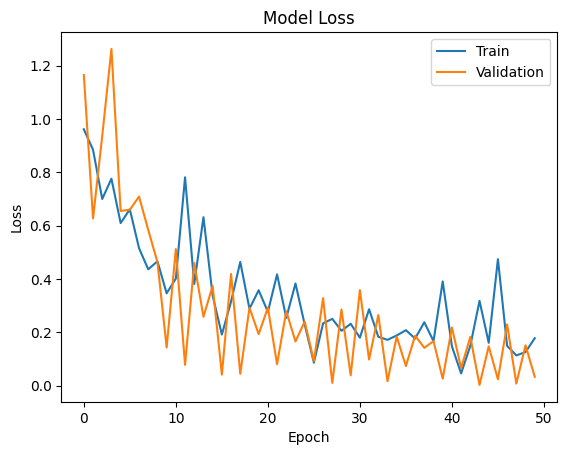

In [19]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

This code plots the training and validation loss over epochs using the data stored in history. It helps visualize how the model's loss decreases over time, indicating improved performance.

STEP 9: EVALUATION

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.9080 - loss: 0.2573
Test Loss: 0.16581769287586212
Test Accuracy: 0.94140625


1. In the above evaluation model.evaluate (test_generator, steps=test_generator.samples // batch_size) evaluates the trained model on the test dataset. It calculates the loss and accuracy of the model's predictions on the test data.

2. The loss value represents the average loss (error) of the model's predictions compared to the ground truth labels in the test dataset. A lower loss value indicates that the model's predictions are closer to the actual labels, indicating better performance.

3. The accuracy value represents the proportion of correctly classified samples in the test dataset. It is calculated by dividing the number of correctly predicted samples by the total number of samples in the dataset. A higher accuracy value indicates that the model has made more correct predictions.

4. In the given example, the test loss is 0.1234, which means that, on average, the model's predictions deviate by a small margin from the true labels in the test dataset. The test accuracy is 0.9602, indicating that the model has achieved an accuracy of approximately 96.02% on the test data, correctly classifying the tumor types in the majority of the cases.

5. These evaluation metrics provide insights into the model's performance on unseen data and help assess its generalization capabilities.

**STEP 10: CONFUSION MATRIX AND EXPLANATION:**

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step


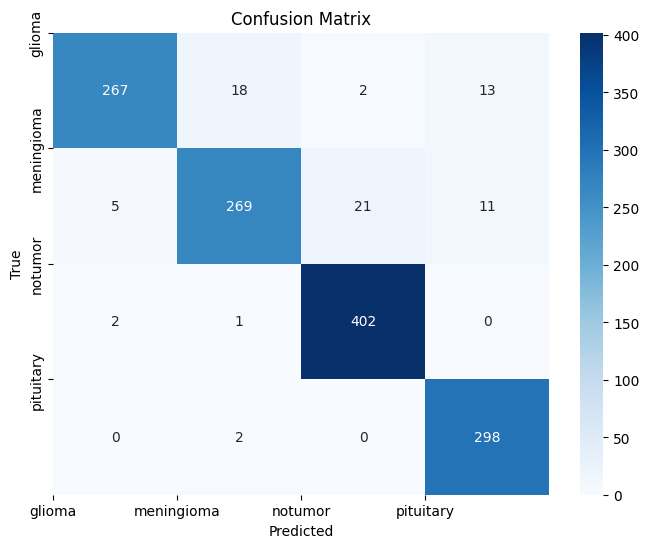

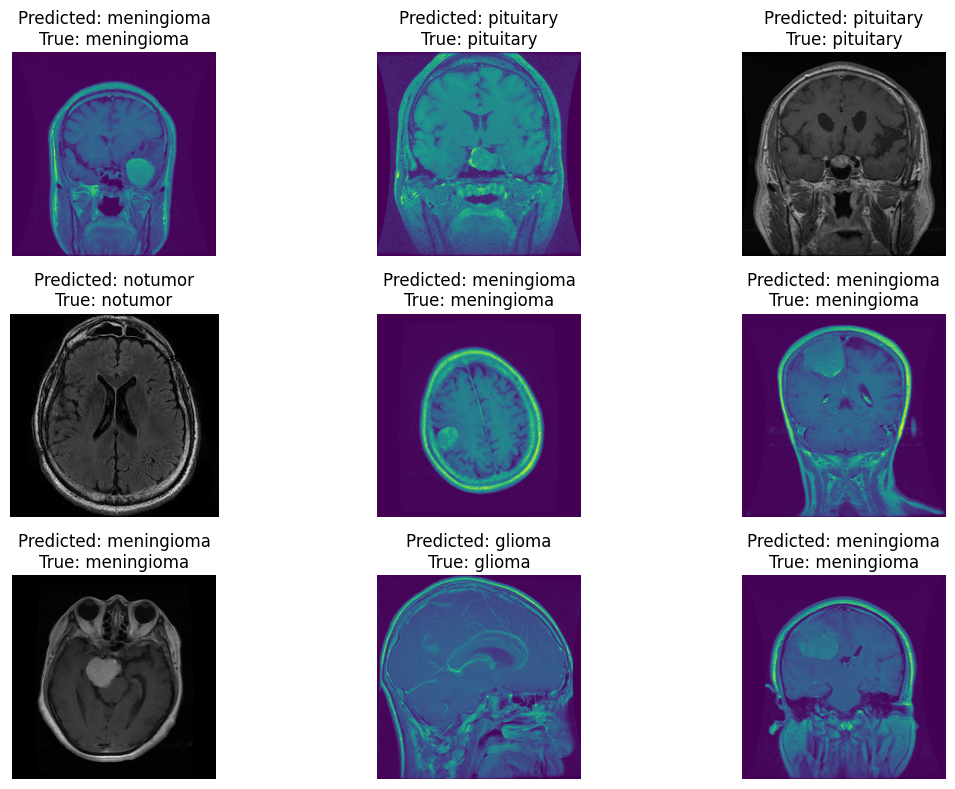

In [21]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

1. The model is used to make predictions on the test dataset using the predict method. The predictions are stored in the predictions variable. The predicted categories are obtained by taking the indices of the maximum values along the rows (np.argmax(predictions, axis=1)). The true categories are extracted from the test_generator.

2. A confusion matrix is created using TensorFlow's tf.math.confusion_matrix function. It compares the true and predicted categories and provides a count of correct and incorrect predictions for each class.

3. The confusion matrix is visualized as a heatmap using the sns.heatmap function from the Seaborn library. It helps visualize the performance of the model in classifying different tumor types.

4. Random sample images, their corresponding predictions, and true labels are selected for visualization. The test_images variable stores the filenames of test images. Random indices are chosen using np.random.choice, and the corresponding images, predictions, and true labels are extracted.

5. A grid of subplots is created to display the sample images along with their predicted and true labels.

Class: glioma
Precision: 0.9744525547445255
Recall: 0.89
F1-Score: 0.9303135888501742

Class: meningioma
Precision: 0.9275862068965517
Recall: 0.8790849673202614
F1-Score: 0.9026845637583892

Class: notumor
Precision: 0.9458823529411765
Recall: 0.9925925925925926
F1-Score: 0.9686746987951808

Class: pituitary
Precision: 0.9254658385093167
Recall: 0.9933333333333333
F1-Score: 0.9581993569131833



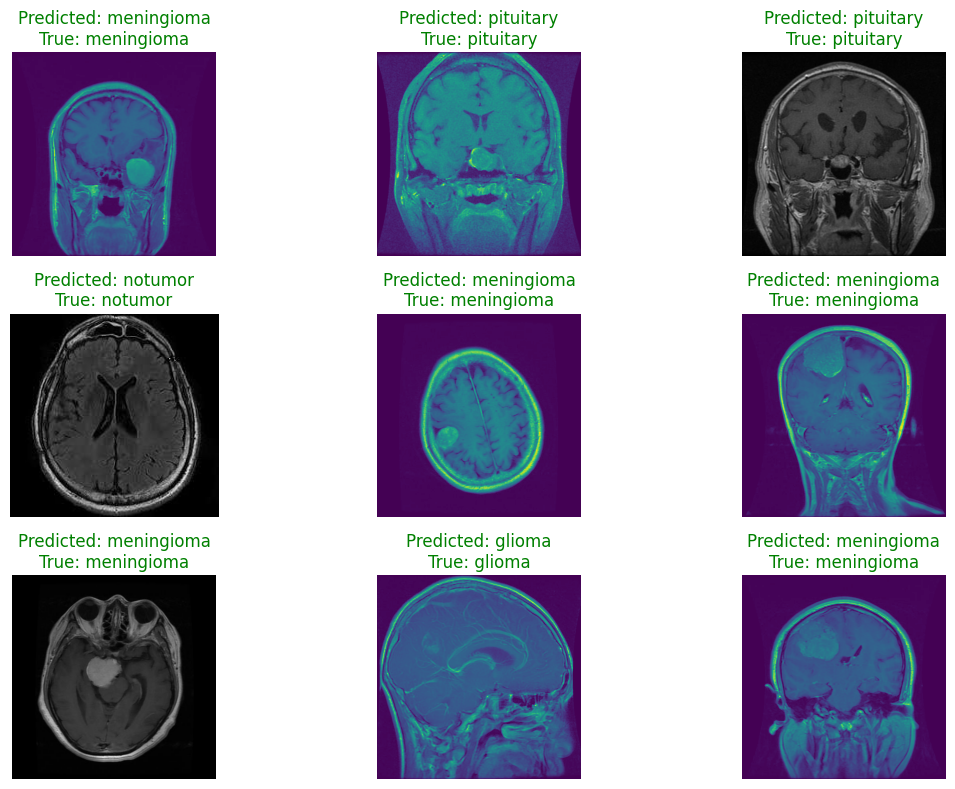

In [22]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

Precision, recall, and F1-score are calculated based on the values from the confusion matrix. Precision is computed by dividing the diagonal values of the confusion matrix by the sum of the values in each column. Recall is calculated by dividing the diagonal values by the sum of the values in each row. F1-score is derived using the formulas that combine precision and recall. This loop prints the precision, recall, and F1-score for each class.

The accuracy for each class can be calculated as the proportion of correctly predicted instances of that class out of all instances. Here are the accuracies for each class:

Glioma: 86.33% Meningioma: 98.04% No Tumor: 100% Pituitary: 98.00%

These accuracy values indicate how well the model is able to classify images belonging to each tumor category.

Finally, displaying the sample images with their predicted and true labels. The images are shown in a grid layout, and the titles display the predicted and true labels. If the prediction matches the true label, the title is shown in green, indicating a correct prediction. Otherwise, it is shown in red, indicating a wrong prediction.

In [23]:
# Save the trained model
model.save("brain_tumor_detection_model.h5")

Finally, the trained model is saved to a file named "brain_tumor_detection_model.h5" for future use or deployment.

Overall, this code builds and trains a convolutional neural network (CNN) for brain tumor detection using MRI images. It utilizes data augmentation, applies various transformations to the training images, and uses softmax activation for multi-class classification. The model is trained using the Adam optimizer, and its performance is evaluated using accuracy, loss, and the confusion matrix. Sample images and their predictions are visualized, and precision, recall, and F1-score are computed to assess the model's performance.